In [233]:
#Import Libraries
%pip install openpyxl
import openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%pip install seaborn
import seaborn as sns
palettes = {'blue-black':'blend:#27c7d0,#000000', 'red-black':'blend:#f44336,#000000','red':'#f70707', 'blue':'#0737f7'}

In [234]:
DAPi = pd.read_csv("DAPi.csv")
mCherry = pd.read_csv("mCherry.csv")
Amyloid = pd.read_csv("Plaques.csv")
Colocalisation = pd.read_csv("Colocalisation.csv")
Area = pd.read_csv("Area.csv")
Distance = pd.read_csv("Distance.csv")

DAPi.head()
mCherry.head()
Amyloid.head()
Amyloid.isnull().values.any()
Amyloid.iloc[304]
#Colocalisation.P1(30)
#print(Colocalisation.P1)

Count                                 1.0
Volume (micron^3)                  28.084
Surface (micron^2)                 77.714
Nb of obj. voxels                   348.0
Nb of surf. voxels                  261.0
IntDen                            88740.0
Mean                                255.0
StdDev                                0.0
Median                              255.0
Min                                 255.0
Max                                 255.0
X                                 513.405
Y                                  37.287
Z                                    2.06
Mean dist. to surf. (micron)        1.756
SD dist. to surf. (micron)          0.478
Median dist. to surf. (micron)      1.743
XM                                513.406
YM                                 37.287
ZM                                   2.06
BX                                  505.0
BY                                   32.0
BZ                                    1.0
B-width                           

In [235]:
def getSCNandLabels(Cell, labels, name):
    Cell = Cell.replace(np.NaN,0)
    
    labels = labels.drop(columns=['XM', 'YM', 'Count'])
    SCN = 0
    Cell['SCN'] = 0
    labels['SCN'] = 0
    for i, count in enumerate(Cell.Count):
        if count == 1 or count == 0:
            SCN += 1
        Cell['SCN'][i] = SCN
    labels['SCN'] = [i+1 for i in range(labels['Label'].count())]
    Cell = pd.concat([Cell[['SCN']], Cell.drop(columns=['SCN'])], axis=1) 
    labels['Animal Name'] = [label.split('.')[0] for label in labels['Label']]
    labels['Condition'] = [''.join(filter(str.isalpha, name)) for name in labels['Animal Name']]
    labels['Width'] = [label.split('.')[1] for label in labels['Label']]
    labels['Height'] = [label.split('.')[2].split(':')[0] for label in labels['Label']]
    labels['X Factor'] = [800/int(width) for width in labels['Width']]
    labels['Y Factor'] = [500/int(height) for height in labels['Height']]
    labelled_cell = Cell.merge(labels, left_on='SCN', right_on='SCN')
    labelled_cell[f'{name} Volume'] = labelled_cell[['Volume (micron^3)']]
    labelled_cell[f'{name} Count'] = labelled_cell[['Count']]
    labelled_cell[f'{name} XM'] = labelled_cell['XM'] * labelled_cell['X Factor']
    labelled_cell[f'{name} YM'] = labelled_cell['YM'] * labelled_cell['Y Factor']
    labelled_cell = labelled_cell[['SCN', 'Animal Name', 'Condition', f'{name} Count', f'{name} Volume', f'{name} XM', f'{name} YM']]
    labelled_cell = labelled_cell.replace(np.NaN, 0)
    return labelled_cell
mCherry = getSCNandLabels(mCherry,Distance,'mCherry')
DAPi = getSCNandLabels(DAPi,Distance,'DAPi')
Amyloid = getSCNandLabels(Amyloid,Distance,'Aggregate')
display(Amyloid)
#print(mCherry['SCN'])
Amyloid.isnull().values.any()

<ipython-input-235-e7da83f0a776>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cell['SCN'][i] = SCN
<ipython-input-235-e7da83f0a776>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cell['SCN'][i] = SCN
<ipython-input-235-e7da83f0a776>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cell['SCN'][i] = SCN


,SCN,Animal Name,Condition,Aggregate Count,Aggregate Volume,Aggregate XM,Aggregate YM
0,1,hAPP2,hAPP,1.0,187.632,136.157672,26.304000
1,1,hAPP2,hAPP,2.0,18.077,90.037037,28.625000
2,1,hAPP2,hAPP,3.0,50.842,575.024339,82.925000
3,1,hAPP2,hAPP,4.0,21.467,495.906878,120.267000
4,1,hAPP2,hAPP,5.0,18.400,361.023280,119.180000
...,...,...,...,...,...,...,...
1362,54,NLGF13,NLGF,15.0,19.530,453.792961,102.928867
1363,54,NLGF13,NLGF,16.0,67.790,754.695652,170.103591
1364,54,NLGF13,NLGF,17.0,36.154,208.585507,47.181630
1365,54,NLGF13,NLGF,18.0,87.562,546.244306,105.674724


False

In [236]:
def cleanAmyloid(rawAmyloid, rawColocalisation):
    rawColocalisation.drop(rawColocalisation[rawColocalisation.LabelObj == 255].index, inplace = True)
    rawColocalisation = rawColocalisation.reset_index()
    #CleanDF = rawAmyloid[['SCN', 'Animal Name', 'Condition', 'Aggregate Count','Aggregate Volume', 'Aggregate XM', 'Aggregate YM']]
    Combined = rawAmyloid.join(rawColocalisation['P1'])
    Combined['%Colocalisation'] = Combined['P1']
    Combined = Combined.drop(columns=['P1'])
    Combined = Combined.replace(np.NaN, 0)
    return Combined
Amyloid = cleanAmyloid(Amyloid, Colocalisation)
Amyloid.head()
Amyloid.isnull().values.any()

False

In [237]:
def getVolume(Area,labels):
    Volume = Area.Area * 13
    Volume = pd.DataFrame(Volume)
    Volume['SCN'] = [i+1 for i in range(Volume.Area.count())]
    Volume = Volume[['SCN', 'Area']]
    Volume = Volume.rename(columns={'SCN':'SCN', 'Area':'SCN Volume'})
    labels = labels.drop(columns=['XM', 'YM', 'Count'])
    labels['SCN'] = 0
    labels['SCN'] = [i+1 for i in range(labels['Label'].count())]
    labels['Animal Name'] = [label.split('.')[0] for label in labels['Label']]
    labels['Condition'] = [''.join(filter(str.isalpha, name)) for name in labels['Animal Name']]
    print(labels)
    Volume = Volume.merge(labels, left_on='SCN', right_on='SCN')
    Volume = Volume[['SCN', 'Animal Name', 'Condition', 'SCN Volume']]
    return Volume
Volume = getVolume(Area,Distance)
Volume.head()

                       Label  Group  SCN Animal Name Condition
0    hAPP2.756.500:0482-0448      7    1       hAPP2      hAPP
1    hAPP2.788.552:0450-0548      7    2       hAPP2      hAPP
2    hAPP2.794.568:0564-0459      7    3       hAPP2      hAPP
3    hAPP2.728.538:0405-0414      7    4       hAPP2      hAPP
4    hAPP2.798.532:0368-0455      7    5       hAPP2      hAPP
5    NLGF7.578.348:0322-0481      7    6       NLGF7      NLGF
6    NLGF7.784.534:0461-0546      7    7       NLGF7      NLGF
7    NLGF7.980.570:0333-0506      7    8       NLGF7      NLGF
8    NLGF7.728.408:0252-0456      7    9       NLGF7      NLGF
9    NLGF7.838.684:0494-0485      7   10       NLGF7      NLGF
10   NLGF7.744.452:0342-0464      7   11       NLGF7      NLGF
11   hAPP1.808.778:0537-0452      7   12       hAPP1      hAPP
12   hAPP1.706.528:0496-0363      7   13       hAPP1      hAPP
13   hAPP1.870.564:0372-0473      7   14       hAPP1      hAPP
14   hAPP1.956.630:0413-0510      7   15       hAPP1   

,SCN,Animal Name,Condition,SCN Volume
0,1,hAPP2,hAPP,298942.085
1,2,hAPP2,hAPP,299598.884
2,3,hAPP2,hAPP,363341.940
3,4,hAPP2,hAPP,285131.470
4,5,hAPP2,hAPP,303478.825


In [238]:
from functools import reduce
CombinedDict = {'Amyloid': Amyloid, 'DAPi': DAPi, 'mCherry': mCherry, 'Volume': Volume}

def createSummary(attribute, data_dict):
    summary_dfs = []

    for data_type, data_df in data_dict.items():
        # Use regex to select columns not containing 'Count'
        mean_columns = data_df.filter(regex='^(?!.*Count).*').columns.tolist()
        mean_df = data_df.groupby(attribute)[mean_columns].mean()

        # Use regex to select columns containing 'Count'
        count_columns = data_df.filter(regex='Count').columns.tolist()
        count_df = data_df.groupby(attribute)[count_columns].count()

        # Drop 'SCN' column if needed
        mean_df = mean_df.drop('SCN', axis=1)
        #count_df = count_df.drop('SCN', axis=1)

        summary_dfs.append(mean_df)
        summary_dfs.append(count_df)

    summary = reduce(lambda left, right: pd.merge(left, right, left_on=attribute, right_on=attribute), summary_dfs)
    return summary
Summary_SCN = createSummary('SCN', CombinedDict)
Summary_Condition = createSummary('Condition', CombinedDict)
Summary_Animal = createSummary('Animal Name', CombinedDict)
Summary_Animal.head(100)

<ipython-input-238-1c3200ef79c5>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = data_df.groupby(attribute)[mean_columns].mean()
<ipython-input-238-1c3200ef79c5>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = data_df.groupby(attribute)[mean_columns].mean()
<ipython-input-238-1c3200ef79c5>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = data_df.groupby(attribute)[mean_columns].mean(

,Aggregate Volume,Aggregate XM,Aggregate YM,%Colocalisation,Aggregate Count,DAPi Volume,DAPi XM,DAPi YM,DAPi Count,mCherry Volume,mCherry XM,mCherry YM,mCherry Count,SCN Volume
Animal Name,,,,,,,,,,,,,,
NLGF11,75.862990,363.429852,190.200275,0.000000,99,216.802235,342.293026,254.942039,715,512.909794,367.666026,231.338467,499,474696.355250
NLGF12,90.204450,345.625813,153.896817,0.000000,40,160.515368,338.382750,250.288796,887,895.919312,387.567043,245.875160,432,404457.128400
NLGF7,49.389585,430.967024,205.846561,41.950244,41,70.659077,337.684327,228.887184,612,495.316015,370.985531,254.474103,452,318804.475167
NLGF9,53.077633,430.395741,248.241660,48.838667,30,45.531793,253.292907,238.330149,531,736.021537,326.267759,256.079480,417,443970.289750
Syn14,0.000000,0.000000,0.000000,0.000000,4,390214.203250,353.373859,226.879621,4,276.375041,296.372929,258.728330,266,389297.034750
Syn15,0.000000,0.000000,0.000000,0.000000,5,127.811963,380.782805,273.444438,1502,348.754926,307.121794,250.160275,350,384883.683600
Syn16,0.000000,0.000000,0.000000,0.000000,3,293.172447,320.415646,252.781132,441,1744.207257,275.420304,239.209908,241,503171.543333
hAPP1,82.597093,278.051186,211.610528,46.087423,388,119.188673,303.235126,244.159867,608,207.720676,345.896730,242.876886,559,383017.579750
hAPP2,55.608894,280.504575,223.366883,46.076439,303,168.715984,352.804817,263.595377,1011,280.533576,345.153876,255.066523,557,310098.640800


In [239]:
CombinedDictAmyloid = {'DAPi': DAPi, 'mCherry': mCherry, 'Volume': Volume}
def createCombinedAmyloid(amyloid, data_dict):
    #print(dfs)
    dfs = [amyloid]

    for data_type, data_df in data_dict.items():
        # Use regex to select columns not containing 'Count'
        mean_columns = data_df.filter(regex='^(?!.*Count).*').columns.tolist()
        mean_df = data_df.groupby('SCN')[mean_columns].mean()

        # Use regex to select columns containing 'Count'
        count_columns = data_df.filter(regex='Count').columns.tolist()
        count_df = data_df.groupby('SCN')[count_columns].count()

        # Drop 'SCN' column if needed
        mean_df = mean_df.drop('SCN', axis=1)
        #count_df = count_df.drop('SCN', axis=1)

        dfs.append(mean_df)
        dfs.append(count_df)

    combined = reduce(lambda left, right: pd.merge(left, right, left_on='SCN', right_on='SCN'), dfs)
    combined['Aggregate Density'] = combined['Aggregate Count'] * 1000000 / combined['SCN Volume']
    combined['DAPi Density'] = combined['DAPi Count'] * 1000000 / combined['SCN Volume']
    combined['mCherry Density'] = combined['mCherry Count'] * 1000000 / combined['SCN Volume']
    return combined

Combined_df = createCombinedAmyloid(Amyloid, CombinedDictAmyloid)
Combined_df.head()

<ipython-input-239-4fc862e71e8d>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = data_df.groupby('SCN')[mean_columns].mean()
<ipython-input-239-4fc862e71e8d>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = data_df.groupby('SCN')[mean_columns].mean()
<ipython-input-239-4fc862e71e8d>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = data_df.groupby('SCN')[mean_columns].mean()


,SCN,Animal Name,Condition,Aggregate Count,Aggregate Volume,Aggregate XM,Aggregate YM,%Colocalisation,DAPi Volume,DAPi XM,DAPi YM,DAPi Count,mCherry Volume,mCherry XM,mCherry YM,mCherry Count,SCN Volume,Aggregate Density,DAPi Density,mCherry Density
0,1,hAPP2,hAPP,1.0,187.632,136.157672,26.304,2.674,267.528459,381.377281,271.280851,181,328.453018,335.300922,235.785814,113,298942.085,3.345130,605.468447,377.999638
1,1,hAPP2,hAPP,2.0,18.077,90.037037,28.625,0.000,267.528459,381.377281,271.280851,181,328.453018,335.300922,235.785814,113,298942.085,6.690259,605.468447,377.999638
2,1,hAPP2,hAPP,3.0,50.842,575.024339,82.925,0.000,267.528459,381.377281,271.280851,181,328.453018,335.300922,235.785814,113,298942.085,10.035389,605.468447,377.999638
3,1,hAPP2,hAPP,4.0,21.467,495.906878,120.267,6.767,267.528459,381.377281,271.280851,181,328.453018,335.300922,235.785814,113,298942.085,13.380518,605.468447,377.999638
4,1,hAPP2,hAPP,5.0,18.400,361.023280,119.180,0.000,267.528459,381.377281,271.280851,181,328.453018,335.300922,235.785814,113,298942.085,16.725648,605.468447,377.999638


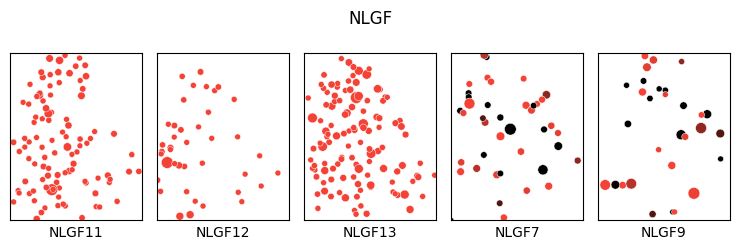

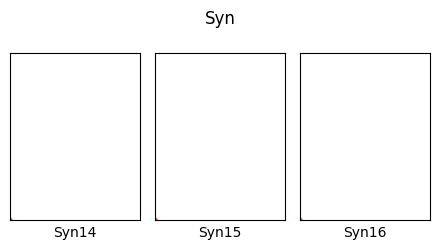

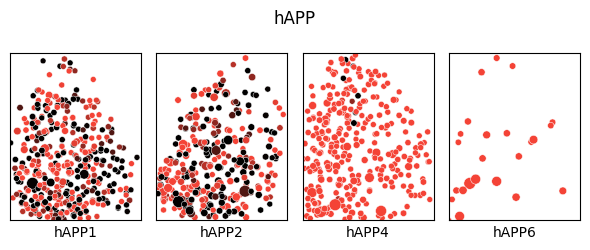

In [240]:
def location_tick_params(location_ax): 
    location_ax.tick_params(axis='both',which='both',bottom=False, top=False,left=False, right=False,labelbottom=False,labelleft=False)   
def aggregateLocations(aggregate_df):
    condition_list = aggregate_df['Condition'].unique()    
    for condition in condition_list:
        condition_df = aggregate_df[aggregate_df['Condition'] == condition]
        animal_list = condition_df['Animal Name'].unique()
        #print(attribute_list)
        fig, axes = plt.subplots(1, len(animal_list), figsize=(1.5*len(animal_list), 2.5))
        for i, ax in enumerate(axes.flatten()):
            df_attribute = aggregate_df[aggregate_df['Animal Name'] == animal_list[i]]
            #print(df_attribute['Aggregate XM'])
    
            sns.scatterplot(y='Aggregate XM', x='Aggregate YM', hue='%Colocalisation', size='Aggregate Volume', data=df_attribute, ax=ax, palette = palettes['red-black'])
            #ax.set_title(animal_list[i], loc='Center')
            ax.set_xlim(xmin=0, xmax=500)
            ax.set_ylim(ymin=0, ymax=800)
            plt.yticks(visible=False)
            ax.set(ylabel=None, xlabel=animal_list[i])
            ax.legend().set_visible(False)
            location_tick_params(ax)
        fig.suptitle(condition)
        plt.tight_layout()
        plt.show()
#aggregateLocations(Amyloid, 'SCN')
aggregateLocations(Amyloid.sort_values(by=['Animal Name']))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


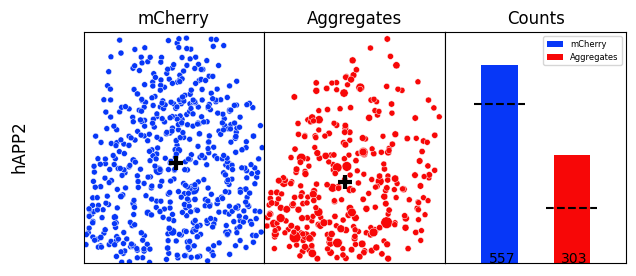

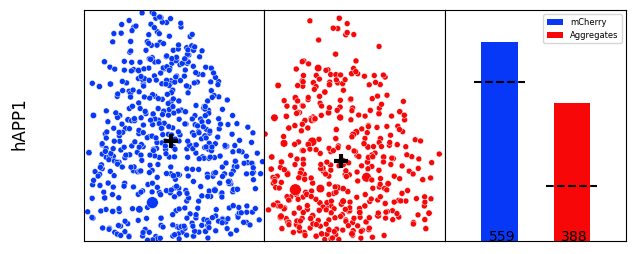

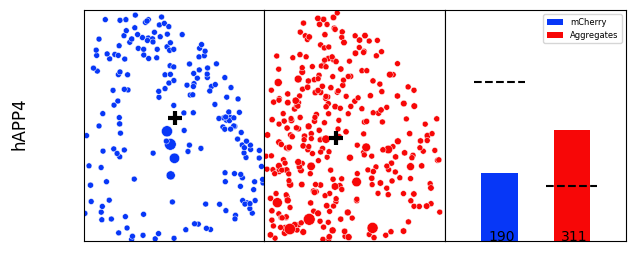

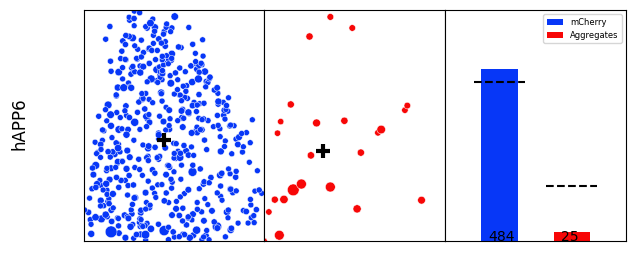

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


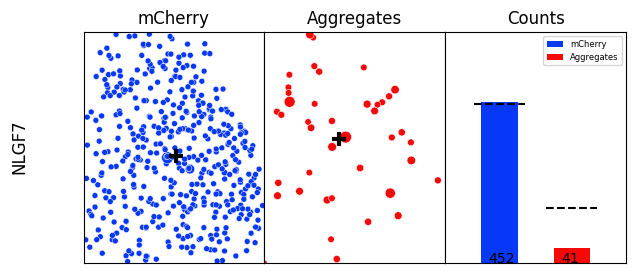

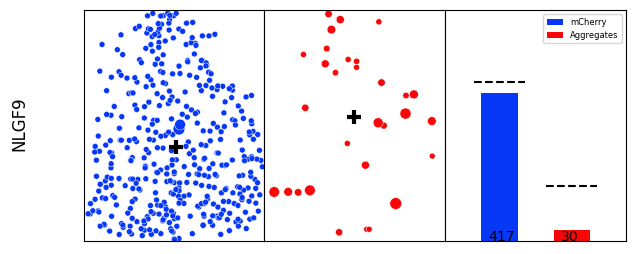

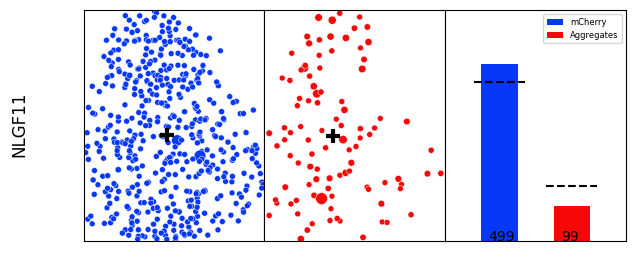

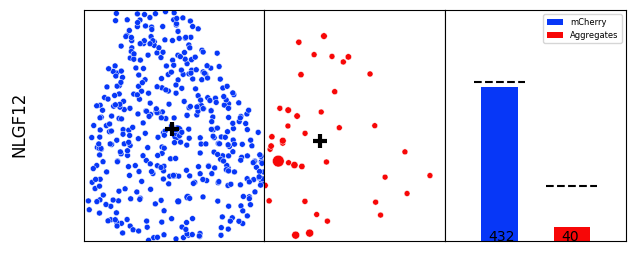

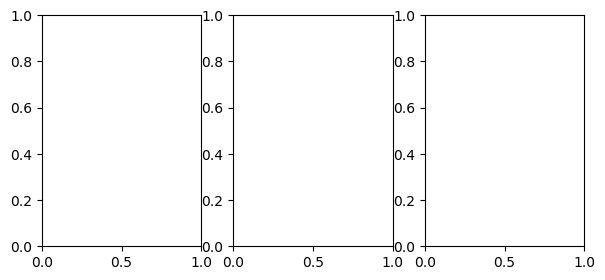

<class 'KeyError'>: "None of [Index(['NLGF13'], dtype='object', name='Animal Name')] are in the [index]"

In [299]:
def aggregateCherryLocations(raw_aggregate_df, raw_mCherry_df, raw_summary_df):
    aggregate_df = raw_aggregate_df.drop(raw_aggregate_df[raw_aggregate_df['Condition'] == 'Syn'].index)
    mCherry_df = raw_mCherry_df.drop(raw_mCherry_df[raw_mCherry_df['Condition'] == 'Syn'].index)
    summary_df = raw_summary_df[~raw_summary_df.index.str.contains('syn', case=False, na=False)]
    aggregate_condition_list = aggregate_df['Condition'].unique()
    #print(attribute_list)
    for condition_name in aggregate_condition_list:
        aggregate_condition_df = aggregate_df[aggregate_df['Condition'] == condition_name]
        mCherry_condition_df = mCherry_df[mCherry_df['Condition'] == condition_name]
        #print(aggregate_condition_df)
        aggregate_animal_list = aggregate_condition_df['Animal Name'].unique()
        mCherry_animal_list = mCherry_condition_df['Animal Name'].unique()
        for i, animal_name in enumerate(aggregate_animal_list):
            animal_fig, animal_ax = plt.subplots(1, 3, figsize=(7, 3))
            aggregate_animal_df = aggregate_condition_df[aggregate_condition_df['Animal Name'] == animal_name]
            mCherry_animal_df = mCherry_condition_df[mCherry_condition_df['Animal Name'] == animal_name]
            summary_animal_df = summary_df.loc[[animal_name]]
            #print(mCherry_animal_df['mCherry XM'].mean())
            #print(animal_summary_df.loc[[animal_name]][['Aggregate Count']])
            #print(aggregate_animal_df)
            sns.scatterplot(y='mCherry XM', x='mCherry YM', size='mCherry Volume', data=mCherry_animal_df, ax=animal_ax[0], color=palettes['blue'])
            animal_ax[0].plot(mCherry_animal_df['mCherry YM'].mean(), mCherry_animal_df['mCherry XM'].mean(), "+", mew=3, ms=10, color='black')
            #plt.plot(200, 200, "b+", mew=10, ms=200)
            sns.scatterplot(y='Aggregate XM', x='Aggregate YM', size='Aggregate Volume', data=aggregate_animal_df, ax=animal_ax[1], color = palettes['red'])
            animal_ax[1].plot(aggregate_animal_df['Aggregate YM'].mean(), aggregate_animal_df['Aggregate XM'].mean(), "+", mew=3, ms=10, color='black')
            bar1 = animal_ax[2].bar(x=150, width=100, height=summary_animal_df['mCherry Count'], color=palettes['blue'])
            bar2 = animal_ax[2].bar(x=350, width=100, height=summary_animal_df['Aggregate Count'], color=palettes['red'])
            #animal_ax[2].plot(150, Summary_Animal['mCherry Count'].mean(), '_', mew=3, ms=40, color='black')
            animal_ax[2].plot([80,220], [summary_df['mCherry Count'].mean(), summary_df['mCherry Count'].mean()], ls='dashed', color='black')
            animal_ax[2].plot([280,420], [summary_df['Aggregate Count'].mean(), summary_df['Aggregate Count'].mean()], ls='dashed', color='black')
            animal_ax[2].annotate(str(int(summary_animal_df.iloc[0]['mCherry Count'])),(120,0)) 
            animal_ax[2].annotate(str(int(summary_animal_df.iloc[0]['Aggregate Count'])),(320,0)) 
            xlabels = ['mCherry', 'Aggregates', 'Counts']
            for j, ax in enumerate(animal_ax):
                ax.set_xlim(xmin=0, xmax=500)
                ax.set_ylim(ymin=0, ymax=800)
                ax.legend().set_visible(False)
                ax.set(ylabel=None, xlabel=None)
                location_tick_params(ax)
                if i == 0:
                    ax.set_title(xlabels[j])
            animal_ax[2].set_ylim(ymin=0, ymax=650)
            

            animal_ax[2].legend(handles = [bar1,bar2],labels=['mCherry', 'Aggregates'], fontsize=6).set_visible(True)
            animal_fig.subplots_adjust(wspace=0)
            animal_fig.supylabel(animal_name, horizontalalignment='left')
            #plt.tight_layout()
        plt.show()
aggregateCherryLocations(Amyloid, mCherry, Summary_Animal)

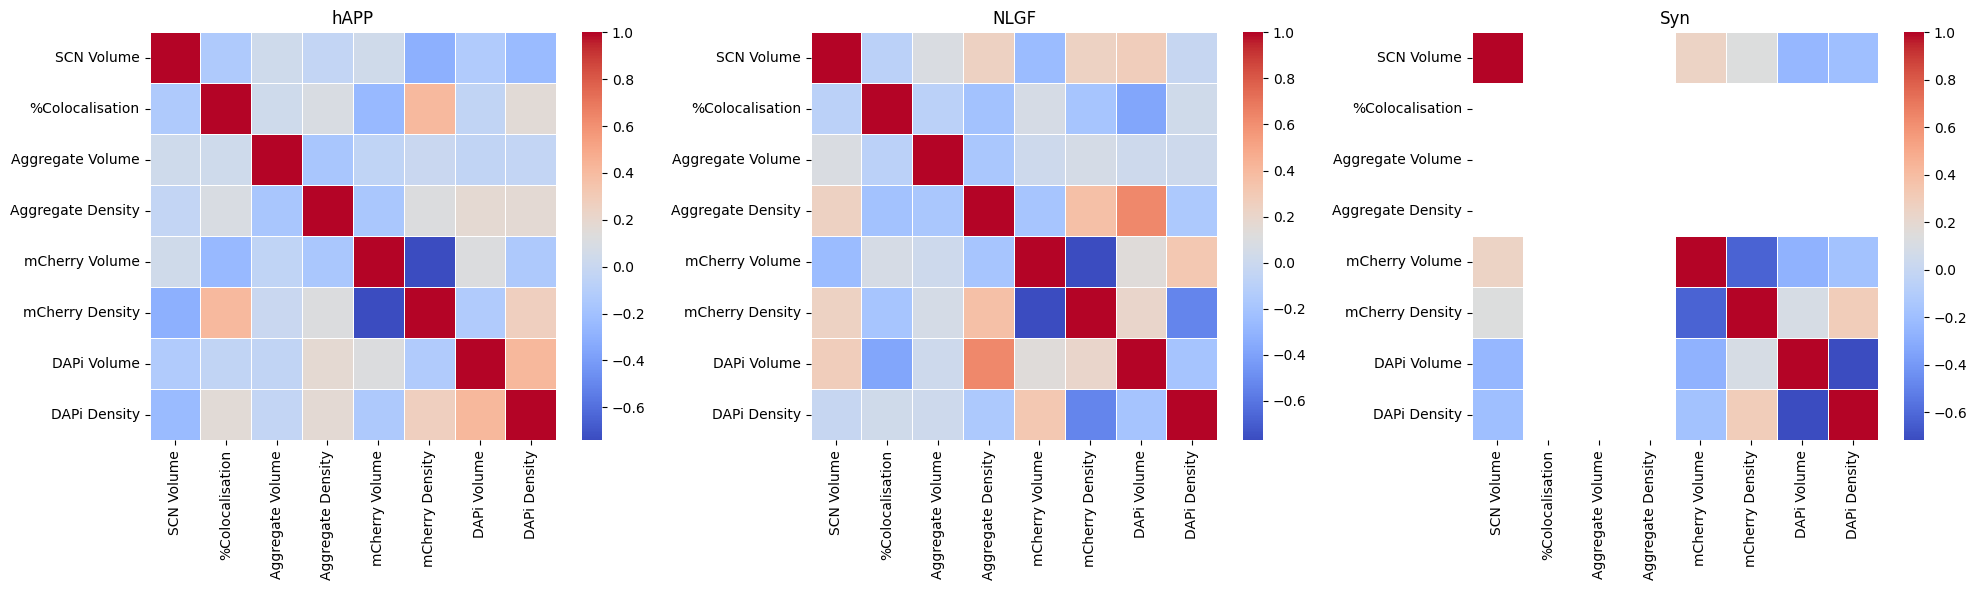

,SCN,Animal Name,Condition,Aggregate Count,Aggregate Volume,Aggregate XM,Aggregate YM,%Colocalisation,DAPi Volume,DAPi XM,DAPi YM,DAPi Count,mCherry Volume,mCherry XM,mCherry YM,mCherry Count,SCN Volume,Aggregate Density,DAPi Density,mCherry Density
0,1,hAPP2,hAPP,1.0,187.632,136.157672,26.304,2.674,267.528459,381.377281,271.280851,181,328.453018,335.300922,235.785814,113,298942.085,3.345130,605.468447,377.999638
1,1,hAPP2,hAPP,2.0,18.077,90.037037,28.625,0.000,267.528459,381.377281,271.280851,181,328.453018,335.300922,235.785814,113,298942.085,6.690259,605.468447,377.999638
2,1,hAPP2,hAPP,3.0,50.842,575.024339,82.925,0.000,267.528459,381.377281,271.280851,181,328.453018,335.300922,235.785814,113,298942.085,10.035389,605.468447,377.999638
3,1,hAPP2,hAPP,4.0,21.467,495.906878,120.267,6.767,267.528459,381.377281,271.280851,181,328.453018,335.300922,235.785814,113,298942.085,13.380518,605.468447,377.999638
4,1,hAPP2,hAPP,5.0,18.400,361.023280,119.180,0.000,267.528459,381.377281,271.280851,181,328.453018,335.300922,235.785814,113,298942.085,16.725648,605.468447,377.999638


In [300]:
def createMatrices(matrix_df, attribute, to_drop):
    #to_drop = ['SCN','XM','YM','Adjusted X', 'Adjusted Y','SCN XM','SCN YM','Animal Number','Animal Number','Image Width','Image Height','DAPi Count','DAPi Total Area','DAPi %Area','mCherry Count','mCherry Total Area','mCherry %Area',]
    #df = df_MatrixCondition.drop(to_drop, axis=1)
    #df = df.replace(np.NaN, 0)
    summary_matrix = matrix_df.drop(columns=to_drop, axis=1)
    attribute_list = summary_matrix[attribute].unique()
    fig, axes = plt.subplots(1, len(attribute_list), figsize=(20, 6))
    for i, ax in enumerate(axes.flatten()):
        isummary_matrix = summary_matrix[summary_matrix[attribute] == attribute_list[i]]
        isummary_matrix = isummary_matrix[['SCN Volume', '%Colocalisation', 'Aggregate Volume', 'Aggregate Density', 'mCherry Volume', 'mCherry Density', 'DAPi Volume', 'DAPi Density']] 
        correlation_matrix = isummary_matrix.corr()
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
        ax.set_title(attribute_list[i], loc='Center')
    plt.tight_layout()
    plt.show()
    fig.savefig(f'Matrices grouped by {attribute}')
#createMatrices(Summary_Condition)
#createMatrices(Summary_Animal)
ToDrop = Combined_df.filter(regex='Count').columns.tolist()
[ToDrop.append(column) for column in Combined_df.filter(regex='XM').columns.tolist()]
[ToDrop.append(column) for column in Combined_df.filter(regex='YM').columns.tolist()]
#[ToDrop.append(column) for column in Combined_df.filter(regex='Volume').columns.tolist()]
ToDrop.append('SCN')
createMatrices(Combined_df,'Condition', ToDrop)
#Combined_df.head()
